# Multi-frequency FDFD
### Introductory example

This example shows how to simulate using FDFD_MF the frequency and spatial profile conversion of an inserted waveguide mode by appropriately choosing the modulation depth and phase profiles. Reproduces the unoptimized structure in J. Wang et al., "Adjoint-based optimization of active nanophotonic devices", Optics Express 26(3), 2018.

To learn more about the underlying physics of waveguide mode conversion, see Z. Yu and S. Fan, "Complete optical isolation created by indirect interband photonic transitions", Nature Photonics 3(2), 2009.

By Siddharth Buddhiraju (siddharthb@alumni.stanford.edu, www.siddharthbuddhiraju.com)

### Import requisite libraries

In [1]:
import numpy as np
import autograd.numpy as npa
import skimage as sk
import copy

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle, circle_perimeter

import sys
sys.path.append('../')
import ceviche.viz
from ceviche import fdfd_mf_ez, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.modes import insert_mode
# from ceviche.helper import operator_proj, operator_blur 

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

### Define simulation parameters
Defining both the physical and numerical parameters of the simulation. See Figs. 1c-d of the quoted paper to interpret the structure and parameters below.

In [2]:
# Speed of light in vacuum
c0 = 3e+8
# Frequency of the source
omega=243e12 #rad/s and not Hz, typo in the actual paper
# Modulation frequency 
omega_mod=132e12 #rad/s and not THz, typo in the actual paper
# Number of sidebands on each side of central wavelength (total number of bands: 2*Nsb + 1)
Nsb = 1
# Spatial resolution in meters
dl=50e-9
# Number of pixels in the PMLs in each direction
Npml=10
# Background permittivity
eps_bg=1.0
# Waveguide structure's relative permittivity
eps_si=12.25
# Modulation depth in both regions
mod_depth=1.0
# Modulation phases of left and right regions
mod_phi_l = 0
mod_phi_r = np.pi/2
# Number of modulation frequencies (different from number of sidebands) 
Nfreq = 1
# Full width of simulation domain
W=4e-6
# Waveguide thickness
wg_width=1.1e-6
# Central section thickness
wc=2.0e-6
# Full length of simulation domain
L=55e-6
# Length of modulation region on each side
Lmod=19e-6
#Length of central section
Lmid=4.75e-6
# Number of pixels in x-direction
Nx=int(L/dl)
# Number of pixels in y-direction
Ny=int(W/dl) 
# Space between the PMLs and the design region (in pixels)
space=20
# Length in pixels of the source/probe slices on each side of the center point
slice_width=3*wg_width

print('Simulation domain is ' + str(Nx) + 'x' + str(Ny) + ' pixels')

Simulation domain is 1100x80 pixels


### Setup the simulation domain using parameters defined above

In [3]:
def init_domain():
    """Initializes the domain and design region"""
    
    # Permittivity initialization of the structure
    epsr = eps_bg*np.ones((Nx, Ny))

    ## Geometry of waveguide
    # Left waveguide section
    wg_L1 = 0
    wg_L2 = int(Nx/2) - int(Lmid/2/dl)
    # Right waveguide section
    wg_R1 = int(Nx/2) + int(Lmid/2/dl)
    wg_R2 = int(Nx)
    wg_top = int(Ny/2) + int(wg_width/2/dl)
    wg_bot = int(Ny/2) - int(wg_width/2/dl)
    #Central section
    wg_c_top = int(Ny/2) + int(wc/2/dl)
    wg_c_bot = int(Ny/2) - int(wc/2/dl)
    
    ## Permittivity of waveguide
    epsr[wg_L1:wg_L2, wg_bot:wg_top] = eps_si
    epsr[wg_R1:wg_R2, wg_bot:wg_top] = eps_si
    epsr[wg_L2:wg_R1, wg_c_bot:wg_c_top] = eps_si

    # Coordinates of source input 
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2) - int(slice_width/2/dl), int(Ny/2) + int(slice_width/2/dl)))
    
    # Coordinates of probe output
    output_slice = Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2) - int(slice_width/2/dl), int(Ny/2) + int(slice_width/2/dl)))
    
    # Modulation region (delta and phi)
    delta = np.zeros((Nfreq, Nx, Ny))
    delta[:, wg_L2-int(Lmod/dl):wg_L2, int(Ny/2):wg_top] = mod_depth
    delta[:, wg_R1:wg_R1+int(Lmod/dl), int(Ny/2):wg_top] = mod_depth
    phi = np.zeros((Nfreq, Nx, Ny))
    phi[:, wg_L2-int(Lmod/dl):wg_L2, int(Ny/2):wg_top] = mod_phi_l
    phi[:, wg_R1:wg_R1+int(Lmod/dl), int(Ny/2):wg_top] = mod_phi_r
    return epsr, input_slice, output_slice, delta, phi

## Solve for field profiles
### Forward propagation (Fig. 1c)
The modulation region is defined with a `pi/2` phase difference between the left and right modulation regions. Due to the relative order of the phases (`0` followed by `pi/2`), forward propagation through this structure does not result in good conversion from the inserted even mode at `omega` to the odd mode at `omega+omega_mod`.

Text(0.5, 1.0, 'Modulation region')

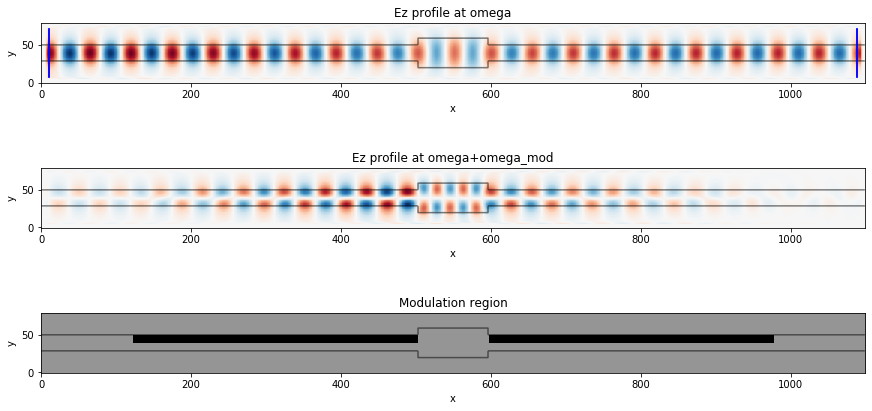

In [4]:
# Initialize the parametrization rho and the design region
epsr, input_slice, output_slice, delta, phi = init_domain()
slices = [input_slice, output_slice]

# Setup source and pad appropriately (notice source is at 'input' slice)
source_0 = np.array([insert_mode(omega, dl, input_slice.x, input_slice.y, epsr, m=1)])
pad_left = np.zeros([Nsb,Nx,Ny])
pad_right = np.zeros([Nsb,Nx,Ny])
source = np.concatenate( (np.concatenate((pad_left, source_0)), pad_right) )

# Define multi-frequency FDFD simulation with the epsr, delta, phi profiles
simulation = fdfd_mf_ez(omega, dl, epsr, omega_mod, delta, phi, Nsb, [Npml, Npml])
# Solve for electric and magnetic fields
Hx, Hy, Ez = simulation.solve(source)

# Plot results
fig, ax = plt.subplots(3,1, constrained_layout=True, figsize=(12,6))
ceviche.viz.real(Ez[Nsb + 0], outline=epsr, ax=ax[0], cbar=False)
ax[0].set_title('Ez profile at omega')
ceviche.viz.real(Ez[Nsb + 1], outline=epsr, ax=ax[1], cbar=False)    
ax[1].set_title('Ez profile at omega+omega_mod')
for sl in slices:
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
ceviche.viz.real(delta[0], outline=epsr, ax=ax[2], cmap='Greys')
ax[2].set_title('Modulation region')

### Backward propagation (Fig. 1d)
In reverse propagation (right to left), the order of the phases is correct (`pi/2` followed by `0`), resulting in good conversion efficiency from the inserted even mode at `omega` to the odd mode at `omega + omega_mod`.

Text(0.5, 1.0, 'Modulation region')

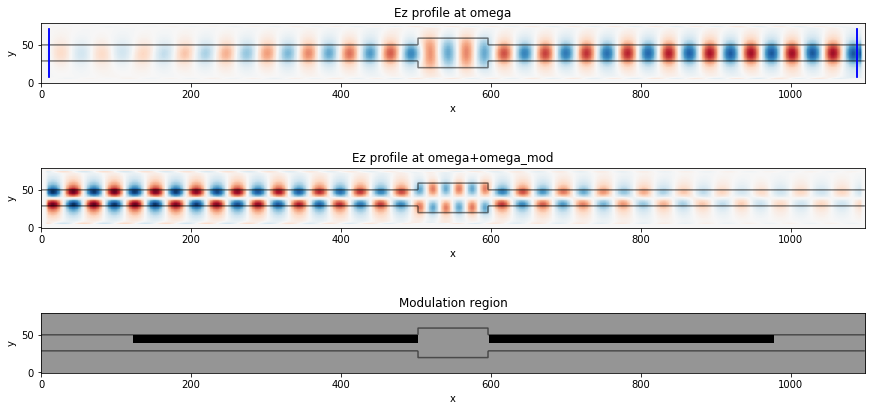

In [5]:
# Initialize the parametrization rho and the design region
epsr, input_slice, output_slice, delta, phi = init_domain()
slices = [input_slice, output_slice]

# Setup source and pad appropriately (notice source is at 'output' slice this time)
source_0 = np.array([insert_mode(omega, dl, output_slice.x, output_slice.y, epsr, m=1)]) 
pad_left = np.zeros([Nsb,Nx,Ny])
pad_right = np.zeros([Nsb,Nx,Ny])
source = np.concatenate( (np.concatenate((pad_left, source_0)), pad_right) )

# Define multi-frequency FDFD simulation with the epsr, delta, phi profiles
simulation = fdfd_mf_ez(omega, dl, epsr, omega_mod, delta, phi, Nsb, [Npml, Npml])
# Solve for electric and magnetic fields
Hx, Hy, Ez = simulation.solve(source)

# Plot results
fig, ax = plt.subplots(3,1, constrained_layout=True, figsize=(12,6))
ceviche.viz.real(Ez[Nsb + 0], outline=epsr, ax=ax[0], cbar=False)
ax[0].set_title('Ez profile at omega')
ceviche.viz.real(Ez[Nsb + 1], outline=epsr, ax=ax[1], cbar=False)    
ax[1].set_title('Ez profile at omega+omega_mod')
for sl in slices:
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
    ax[0].plot(sl.x*np.ones(len(sl.y)), sl.y, 'b-')
ceviche.viz.real(delta[0], outline=epsr, ax=ax[2], cmap='Greys')
ax[2].set_title('Modulation region')